In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_b25_targets_t1_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(884582, 1104)
(884582, 3)
validation
(154411, 1104)
(154411, 3)
test
(115112, 1104)
(115112, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1104)]            0         


 dense (Dense)               (None, 2048)              2263040   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 3)                 387       


Total params: 5050627 (19.27 MB)


Trainable params: 5050627 (19.27 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 1:21 - loss: 1.0874 - STD: 0.0258 - MAE: 0.4414

2/9 [=====>........................] - ETA: 3s - loss: 1.1117 - STD: 0.1052 - MAE: 0.4302  

3/9 [=========>....................] - ETA: 2s - loss: 1.1087 - STD: 0.1147 - MAE: 0.4286

4/9 [============>.................] - ETA: 14s - loss: 1.1033 - STD: 0.1087 - MAE: 0.4298

5/9 [===============>..............] - ETA: 9s - loss: 1.0994 - STD: 0.0930 - MAE: 0.4319 

6/9 [===================>..........] - ETA: 5s - loss: 1.0989 - STD: 0.0803 - MAE: 0.4339

7/9 [======================>.......] - ETA: 3s - loss: 1.0976 - STD: 0.0733 - MAE: 0.4349

8/9 [=========================>....] - ETA: 1s - loss: 1.0950 - STD: 0.0709 - MAE: 0.4352

9/9 [==============================] - ETA: 0s - loss: 1.0925 - STD: 0.0720 - MAE: 0.4349

9/9 [==============================] - 24s 2s/step - loss: 1.0925 - STD: 0.0720 - MAE: 0.4349 - val_loss: 1.0764 - val_STD: 0.1001 - val_MAE: 0.4295


Epoch 2/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0761 - STD: 0.1001 - MAE: 0.4294

2/9 [=====>........................] - ETA: 3s - loss: 1.0785 - STD: 0.1054 - MAE: 0.4286

3/9 [=========>....................] - ETA: 2s - loss: 1.0807 - STD: 0.1077 - MAE: 0.4284

4/9 [============>.................] - ETA: 2s - loss: 1.0802 - STD: 0.1075 - MAE: 0.4284

5/9 [===============>..............] - ETA: 1s - loss: 1.0788 - STD: 0.1051 - MAE: 0.4287

6/9 [===================>..........] - ETA: 1s - loss: 1.0777 - STD: 0.1011 - MAE: 0.4292

7/9 [======================>.......] - ETA: 0s - loss: 1.0770 - STD: 0.0961 - MAE: 0.4300

8/9 [=========================>....] - ETA: 0s - loss: 1.0765 - STD: 0.0906 - MAE: 0.4307

9/9 [==============================] - ETA: 0s - loss: 1.0762 - STD: 0.0853 - MAE: 0.4314

9/9 [==============================] - 5s 519ms/step - loss: 1.0762 - STD: 0.0853 - MAE: 0.4314 - val_loss: 1.0723 - val_STD: 0.0419 - val_MAE: 0.4369


Epoch 3/10000


1/9 [==>...........................] - ETA: 6s - loss: 1.0721 - STD: 0.0421 - MAE: 0.4368

2/9 [=====>........................] - ETA: 3s - loss: 1.0706 - STD: 0.0453 - MAE: 0.4362

3/9 [=========>....................] - ETA: 2s - loss: 1.0684 - STD: 0.0500 - MAE: 0.4352

4/9 [============>.................] - ETA: 2s - loss: 1.0663 - STD: 0.0556 - MAE: 0.4340

5/9 [===============>..............] - ETA: 1s - loss: 1.0644 - STD: 0.0612 - MAE: 0.4326

6/9 [===================>..........] - ETA: 1s - loss: 1.0620 - STD: 0.0664 - MAE: 0.4313

7/9 [======================>.......] - ETA: 0s - loss: 1.0592 - STD: 0.0707 - MAE: 0.4299

8/9 [=========================>....] - ETA: 0s - loss: 1.0555 - STD: 0.0737 - MAE: 0.4284

9/9 [==============================] - ETA: 0s - loss: 1.0506 - STD: 0.0759 - MAE: 0.4268

9/9 [==============================] - 5s 545ms/step - loss: 1.0506 - STD: 0.0759 - MAE: 0.4268 - val_loss: 0.9898 - val_STD: 0.0945 - val_MAE: 0.4086


Epoch 4/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.9886 - STD: 0.0972 - MAE: 0.4077

2/9 [=====>........................] - ETA: 3s - loss: 0.9750 - STD: 0.0975 - MAE: 0.4043

3/9 [=========>....................] - ETA: 2s - loss: 0.9594 - STD: 0.1017 - MAE: 0.3997

4/9 [============>.................] - ETA: 2s - loss: 0.9438 - STD: 0.1090 - MAE: 0.3944

5/9 [===============>..............] - ETA: 1s - loss: 0.9324 - STD: 0.1172 - MAE: 0.3895

6/9 [===================>..........] - ETA: 1s - loss: 0.9215 - STD: 0.1299 - MAE: 0.3833

7/9 [======================>.......] - ETA: 0s - loss: 0.9069 - STD: 0.1402 - MAE: 0.3770

8/9 [=========================>....] - ETA: 0s - loss: 0.9021 - STD: 0.1501 - MAE: 0.3731

9/9 [==============================] - ETA: 0s - loss: 0.8907 - STD: 0.1602 - MAE: 0.3671

9/9 [==============================] - 5s 532ms/step - loss: 0.8907 - STD: 0.1602 - MAE: 0.3671 - val_loss: 0.8213 - val_STD: 0.2561 - val_MAE: 0.3160


Epoch 5/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.8385 - STD: 0.2648 - MAE: 0.3146

2/9 [=====>........................] - ETA: 3s - loss: 0.8039 - STD: 0.2575 - MAE: 0.3122

3/9 [=========>....................] - ETA: 2s - loss: 0.8141 - STD: 0.2537 - MAE: 0.3161

4/9 [============>.................] - ETA: 2s - loss: 0.8023 - STD: 0.2561 - MAE: 0.3127

5/9 [===============>..............] - ETA: 1s - loss: 0.8038 - STD: 0.2611 - MAE: 0.3102

6/9 [===================>..........] - ETA: 1s - loss: 0.7969 - STD: 0.2612 - MAE: 0.3088

7/9 [======================>.......] - ETA: 0s - loss: 0.7992 - STD: 0.2592 - MAE: 0.3100

8/9 [=========================>....] - ETA: 0s - loss: 0.7939 - STD: 0.2598 - MAE: 0.3087

9/9 [==============================] - ETA: 0s - loss: 0.7929 - STD: 0.2630 - MAE: 0.3069

9/9 [==============================] - 5s 538ms/step - loss: 0.7929 - STD: 0.2630 - MAE: 0.3069 - val_loss: 0.7868 - val_STD: 0.2719 - val_MAE: 0.3008


Epoch 6/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.7555 - STD: 0.2795 - MAE: 0.2915

2/9 [=====>........................] - ETA: 3s - loss: 0.7634 - STD: 0.2698 - MAE: 0.2977

3/9 [=========>....................] - ETA: 2s - loss: 0.7593 - STD: 0.2688 - MAE: 0.2975

4/9 [============>.................] - ETA: 2s - loss: 0.7575 - STD: 0.2733 - MAE: 0.2949

5/9 [===============>..............] - ETA: 1s - loss: 0.7562 - STD: 0.2754 - MAE: 0.2937

6/9 [===================>..........] - ETA: 1s - loss: 0.7521 - STD: 0.2732 - MAE: 0.2940

7/9 [======================>.......] - ETA: 0s - loss: 0.7512 - STD: 0.2703 - MAE: 0.2953

8/9 [=========================>....] - ETA: 0s - loss: 0.7478 - STD: 0.2695 - MAE: 0.2951

9/9 [==============================] - ETA: 0s - loss: 0.7462 - STD: 0.2697 - MAE: 0.2948

9/9 [==============================] - 5s 545ms/step - loss: 0.7462 - STD: 0.2697 - MAE: 0.2948 - val_loss: 0.7479 - val_STD: 0.2564 - val_MAE: 0.3021


Epoch 7/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.7249 - STD: 0.2588 - MAE: 0.2962

2/9 [=====>........................] - ETA: 3s - loss: 0.7266 - STD: 0.2516 - MAE: 0.3000

3/9 [=========>....................] - ETA: 2s - loss: 0.7256 - STD: 0.2503 - MAE: 0.3003

4/9 [============>.................] - ETA: 2s - loss: 0.7233 - STD: 0.2538 - MAE: 0.2981

5/9 [===============>..............] - ETA: 1s - loss: 0.7217 - STD: 0.2572 - MAE: 0.2960

6/9 [===================>..........] - ETA: 1s - loss: 0.7194 - STD: 0.2585 - MAE: 0.2949

7/9 [======================>.......] - ETA: 0s - loss: 0.7180 - STD: 0.2592 - MAE: 0.2942

8/9 [=========================>....] - ETA: 0s - loss: 0.7157 - STD: 0.2609 - MAE: 0.2929

9/9 [==============================] - ETA: 0s - loss: 0.7146 - STD: 0.2634 - MAE: 0.2915

9/9 [==============================] - 5s 545ms/step - loss: 0.7146 - STD: 0.2634 - MAE: 0.2915 - val_loss: 0.7238 - val_STD: 0.2818 - val_MAE: 0.2840


Epoch 8/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.6987 - STD: 0.2804 - MAE: 0.2796

2/9 [=====>........................] - ETA: 3s - loss: 0.6979 - STD: 0.2770 - MAE: 0.2813

3/9 [=========>....................] - ETA: 2s - loss: 0.6951 - STD: 0.2770 - MAE: 0.2806

4/9 [============>.................] - ETA: 2s - loss: 0.6936 - STD: 0.2792 - MAE: 0.2791

5/9 [===============>..............] - ETA: 1s - loss: 0.6917 - STD: 0.2804 - MAE: 0.2781

6/9 [===================>..........] - ETA: 1s - loss: 0.6908 - STD: 0.2805 - MAE: 0.2779

7/9 [======================>.......] - ETA: 0s - loss: 0.6895 - STD: 0.2814 - MAE: 0.2772

8/9 [=========================>....] - ETA: 0s - loss: 0.6879 - STD: 0.2830 - MAE: 0.2760

9/9 [==============================] - ETA: 0s - loss: 0.6866 - STD: 0.2840 - MAE: 0.2752

9/9 [==============================] - 5s 543ms/step - loss: 0.6866 - STD: 0.2840 - MAE: 0.2752 - val_loss: 0.7075 - val_STD: 0.2925 - val_MAE: 0.2750


Epoch 9/10000


1/9 [==>...........................] - ETA: 7s - loss: 0.6754 - STD: 0.2888 - MAE: 0.2707

2/9 [=====>........................] - ETA: 3s - loss: 0.6717 - STD: 0.2906 - MAE: 0.2688

3/9 [=========>....................] - ETA: 2s - loss: 0.6689 - STD: 0.2915 - MAE: 0.2678

4/9 [============>.................] - ETA: 2s - loss: 0.6688 - STD: 0.2904 - MAE: 0.2684

5/9 [===============>..............] - ETA: 1s - loss: 0.6682 - STD: 0.2902 - MAE: 0.2685

6/9 [===================>..........] - ETA: 1s - loss: 0.6673 - STD: 0.2909 - MAE: 0.2679

7/9 [======================>.......] - ETA: 0s - loss: 0.6661 - STD: 0.2911 - MAE: 0.2676

8/9 [=========================>....] - ETA: 0s - loss: 0.6654 - STD: 0.2913 - MAE: 0.2674

9/9 [==============================] - ETA: 0s - loss: 0.6644 - STD: 0.2920 - MAE: 0.2668

9/9 [==============================] - 5s 521ms/step - loss: 0.6644 - STD: 0.2920 - MAE: 0.2668 - val_loss: 0.6803 - val_STD: 0.2991 - val_MAE: 0.2663


Epoch 10/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.6563 - STD: 0.2947 - MAE: 0.2639

2/9 [=====>........................] - ETA: 3s - loss: 0.6528 - STD: 0.2955 - MAE: 0.2626

3/9 [=========>....................] - ETA: 2s - loss: 0.6520 - STD: 0.2977 - MAE: 0.2612

4/9 [============>.................] - ETA: 2s - loss: 0.6500 - STD: 0.2984 - MAE: 0.2604

5/9 [===============>..............] - ETA: 1s - loss: 0.6484 - STD: 0.2992 - MAE: 0.2597

6/9 [===================>..........] - ETA: 1s - loss: 0.6471 - STD: 0.3001 - MAE: 0.2590

7/9 [======================>.......] - ETA: 0s - loss: 0.6462 - STD: 0.3005 - MAE: 0.2586

8/9 [=========================>....] - ETA: 0s - loss: 0.6450 - STD: 0.3010 - MAE: 0.2580

9/9 [==============================] - ETA: 0s - loss: 0.6439 - STD: 0.3015 - MAE: 0.2576

9/9 [==============================] - 5s 526ms/step - loss: 0.6439 - STD: 0.3015 - MAE: 0.2576 - val_loss: 0.6577 - val_STD: 0.3099 - val_MAE: 0.2557


Epoch 11/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.6303 - STD: 0.3056 - MAE: 0.2523

2/9 [=====>........................] - ETA: 3s - loss: 0.6314 - STD: 0.3077 - MAE: 0.2513

3/9 [=========>....................] - ETA: 2s - loss: 0.6316 - STD: 0.3071 - MAE: 0.2518

4/9 [============>.................] - ETA: 2s - loss: 0.6353 - STD: 0.3093 - MAE: 0.2511

5/9 [===============>..............] - ETA: 1s - loss: 0.6468 - STD: 0.3069 - MAE: 0.2549

6/9 [===================>..........] - ETA: 1s - loss: 0.6580 - STD: 0.3094 - MAE: 0.2552

7/9 [======================>.......] - ETA: 0s - loss: 0.6532 - STD: 0.3074 - MAE: 0.2555

8/9 [=========================>....] - ETA: 0s - loss: 0.6543 - STD: 0.3059 - MAE: 0.2568

9/9 [==============================] - ETA: 0s - loss: 0.6563 - STD: 0.3076 - MAE: 0.2560

9/9 [==============================] - 5s 524ms/step - loss: 0.6563 - STD: 0.3076 - MAE: 0.2560 - val_loss: 0.6290 - val_STD: 0.3145 - val_MAE: 0.2473


Epoch 12/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.6129 - STD: 0.3112 - MAE: 0.2454

2/9 [=====>........................] - ETA: 3s - loss: 0.6467 - STD: 0.3069 - MAE: 0.2551

3/9 [=========>....................] - ETA: 2s - loss: 0.6442 - STD: 0.3096 - MAE: 0.2526

4/9 [============>.................] - ETA: 2s - loss: 0.6414 - STD: 0.3102 - MAE: 0.2515

5/9 [===============>..............] - ETA: 1s - loss: 0.6436 - STD: 0.3079 - MAE: 0.2535

6/9 [===================>..........] - ETA: 1s - loss: 0.6378 - STD: 0.3074 - MAE: 0.2527

7/9 [======================>.......] - ETA: 0s - loss: 0.6390 - STD: 0.3093 - MAE: 0.2516

8/9 [=========================>....] - ETA: 0s - loss: 0.6355 - STD: 0.3097 - MAE: 0.2507

9/9 [==============================] - ETA: 0s - loss: 0.6351 - STD: 0.3099 - MAE: 0.2507

9/9 [==============================] - 5s 540ms/step - loss: 0.6351 - STD: 0.3099 - MAE: 0.2507 - val_loss: 0.6151 - val_STD: 0.3227 - val_MAE: 0.2388


Epoch 13/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.6148 - STD: 0.3215 - MAE: 0.2387

2/9 [=====>........................] - ETA: 2s - loss: 0.6141 - STD: 0.3196 - MAE: 0.2398

3/9 [=========>....................] - ETA: 2s - loss: 0.6178 - STD: 0.3158 - MAE: 0.2433

4/9 [============>.................] - ETA: 2s - loss: 0.6136 - STD: 0.3146 - MAE: 0.2433

5/9 [===============>..............] - ETA: 1s - loss: 0.6140 - STD: 0.3155 - MAE: 0.2427

6/9 [===================>..........] - ETA: 1s - loss: 0.6107 - STD: 0.3159 - MAE: 0.2419

7/9 [======================>.......] - ETA: 0s - loss: 0.6092 - STD: 0.3163 - MAE: 0.2414

8/9 [=========================>....] - ETA: 0s - loss: 0.6082 - STD: 0.3173 - MAE: 0.2405

9/9 [==============================] - ETA: 0s - loss: 0.6062 - STD: 0.3174 - MAE: 0.2400

9/9 [==============================] - 5s 518ms/step - loss: 0.6062 - STD: 0.3174 - MAE: 0.2400 - val_loss: 0.6377 - val_STD: 0.3200 - val_MAE: 0.2458


Epoch 14/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.6035 - STD: 0.3146 - MAE: 0.2420

2/9 [=====>........................] - ETA: 2s - loss: 0.5976 - STD: 0.3155 - MAE: 0.2395

3/9 [=========>....................] - ETA: 2s - loss: 0.5947 - STD: 0.3166 - MAE: 0.2381

4/9 [============>.................] - ETA: 2s - loss: 0.5936 - STD: 0.3179 - MAE: 0.2373

5/9 [===============>..............] - ETA: 1s - loss: 0.5907 - STD: 0.3194 - MAE: 0.2356

6/9 [===================>..........] - ETA: 1s - loss: 0.5882 - STD: 0.3205 - MAE: 0.2344

7/9 [======================>.......] - ETA: 0s - loss: 0.5876 - STD: 0.3208 - MAE: 0.2342

8/9 [=========================>....] - ETA: 0s - loss: 0.5868 - STD: 0.3210 - MAE: 0.2337

9/9 [==============================] - ETA: 0s - loss: 0.5853 - STD: 0.3212 - MAE: 0.2332

9/9 [==============================] - 5s 522ms/step - loss: 0.5853 - STD: 0.3212 - MAE: 0.2332 - val_loss: 0.6025 - val_STD: 0.3290 - val_MAE: 0.2329


Epoch 15/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5722 - STD: 0.3272 - MAE: 0.2273

2/9 [=====>........................] - ETA: 3s - loss: 0.5780 - STD: 0.3279 - MAE: 0.2272

3/9 [=========>....................] - ETA: 2s - loss: 0.5770 - STD: 0.3285 - MAE: 0.2269

4/9 [============>.................] - ETA: 2s - loss: 0.5742 - STD: 0.3281 - MAE: 0.2263

5/9 [===============>..............] - ETA: 1s - loss: 0.5724 - STD: 0.3275 - MAE: 0.2262

6/9 [===================>..........] - ETA: 1s - loss: 0.5723 - STD: 0.3278 - MAE: 0.2261

7/9 [======================>.......] - ETA: 0s - loss: 0.5730 - STD: 0.3278 - MAE: 0.2261

8/9 [=========================>....] - ETA: 0s - loss: 0.5741 - STD: 0.3285 - MAE: 0.2260

9/9 [==============================] - ETA: 0s - loss: 0.5756 - STD: 0.3285 - MAE: 0.2261

9/9 [==============================] - 5s 526ms/step - loss: 0.5756 - STD: 0.3285 - MAE: 0.2261 - val_loss: 0.5964 - val_STD: 0.3308 - val_MAE: 0.2301


Epoch 16/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5653 - STD: 0.3308 - MAE: 0.2229

2/9 [=====>........................] - ETA: 3s - loss: 0.5590 - STD: 0.3300 - MAE: 0.2217

3/9 [=========>....................] - ETA: 2s - loss: 0.5557 - STD: 0.3305 - MAE: 0.2205

4/9 [============>.................] - ETA: 2s - loss: 0.5565 - STD: 0.3321 - MAE: 0.2198

5/9 [===============>..............] - ETA: 1s - loss: 0.5601 - STD: 0.3324 - MAE: 0.2203

6/9 [===================>..........] - ETA: 1s - loss: 0.5602 - STD: 0.3326 - MAE: 0.2202

7/9 [======================>.......] - ETA: 0s - loss: 0.5590 - STD: 0.3320 - MAE: 0.2203

8/9 [=========================>....] - ETA: 0s - loss: 0.5566 - STD: 0.3322 - MAE: 0.2196

9/9 [==============================] - ETA: 0s - loss: 0.5556 - STD: 0.3333 - MAE: 0.2187

9/9 [==============================] - 5s 542ms/step - loss: 0.5556 - STD: 0.3333 - MAE: 0.2187 - val_loss: 0.5382 - val_STD: 0.3322 - val_MAE: 0.2158


Epoch 17/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.5572 - STD: 0.3391 - MAE: 0.2144

2/9 [=====>........................] - ETA: 3s - loss: 0.5559 - STD: 0.3384 - MAE: 0.2152

3/9 [=========>....................] - ETA: 2s - loss: 0.5528 - STD: 0.3355 - MAE: 0.2163

4/9 [============>.................] - ETA: 2s - loss: 0.5475 - STD: 0.3358 - MAE: 0.2149

5/9 [===============>..............] - ETA: 1s - loss: 0.5448 - STD: 0.3381 - MAE: 0.2129

6/9 [===================>..........] - ETA: 1s - loss: 0.5435 - STD: 0.3389 - MAE: 0.2120

7/9 [======================>.......] - ETA: 0s - loss: 0.5420 - STD: 0.3389 - MAE: 0.2117

8/9 [=========================>....] - ETA: 0s - loss: 0.5409 - STD: 0.3383 - MAE: 0.2118

9/9 [==============================] - ETA: 0s - loss: 0.5390 - STD: 0.3388 - MAE: 0.2111

9/9 [==============================] - 5s 515ms/step - loss: 0.5390 - STD: 0.3388 - MAE: 0.2111 - val_loss: 0.5563 - val_STD: 0.3458 - val_MAE: 0.2115


Epoch 18/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5250 - STD: 0.3506 - MAE: 0.2004

2/9 [=====>........................] - ETA: 3s - loss: 0.5327 - STD: 0.3444 - MAE: 0.2059

3/9 [=========>....................] - ETA: 2s - loss: 0.5363 - STD: 0.3436 - MAE: 0.2073

4/9 [============>.................] - ETA: 2s - loss: 0.5387 - STD: 0.3412 - MAE: 0.2093

5/9 [===============>..............] - ETA: 1s - loss: 0.5355 - STD: 0.3431 - MAE: 0.2074

6/9 [===================>..........] - ETA: 1s - loss: 0.5314 - STD: 0.3440 - MAE: 0.2059

7/9 [======================>.......] - ETA: 0s - loss: 0.5284 - STD: 0.3437 - MAE: 0.2054

8/9 [=========================>....] - ETA: 0s - loss: 0.5264 - STD: 0.3438 - MAE: 0.2049

9/9 [==============================] - ETA: 0s - loss: 0.5255 - STD: 0.3439 - MAE: 0.2046

9/9 [==============================] - 5s 537ms/step - loss: 0.5255 - STD: 0.3439 - MAE: 0.2046 - val_loss: 0.5583 - val_STD: 0.3497 - val_MAE: 0.2091


Epoch 19/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5171 - STD: 0.3535 - MAE: 0.1966

2/9 [=====>........................] - ETA: 3s - loss: 0.5236 - STD: 0.3463 - MAE: 0.2025

3/9 [=========>....................] - ETA: 2s - loss: 0.5204 - STD: 0.3477 - MAE: 0.2010

4/9 [============>.................] - ETA: 2s - loss: 0.5165 - STD: 0.3474 - MAE: 0.2004

5/9 [===============>..............] - ETA: 1s - loss: 0.5116 - STD: 0.3485 - MAE: 0.1986

6/9 [===================>..........] - ETA: 1s - loss: 0.5082 - STD: 0.3487 - MAE: 0.1978

7/9 [======================>.......] - ETA: 0s - loss: 0.5054 - STD: 0.3489 - MAE: 0.1971

8/9 [=========================>....] - ETA: 0s - loss: 0.5037 - STD: 0.3498 - MAE: 0.1961

9/9 [==============================] - ETA: 0s - loss: 0.5043 - STD: 0.3493 - MAE: 0.1966

9/9 [==============================] - 5s 532ms/step - loss: 0.5043 - STD: 0.3493 - MAE: 0.1966 - val_loss: 0.5691 - val_STD: 0.3580 - val_MAE: 0.2053


Epoch 20/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5158 - STD: 0.3604 - MAE: 0.1913

2/9 [=====>........................] - ETA: 3s - loss: 0.5275 - STD: 0.3512 - MAE: 0.2002

3/9 [=========>....................] - ETA: 2s - loss: 0.5237 - STD: 0.3542 - MAE: 0.1972

4/9 [============>.................] - ETA: 2s - loss: 0.5160 - STD: 0.3528 - MAE: 0.1966

5/9 [===============>..............] - ETA: 1s - loss: 0.5081 - STD: 0.3534 - MAE: 0.1944

6/9 [===================>..........] - ETA: 1s - loss: 0.5040 - STD: 0.3541 - MAE: 0.1931

7/9 [======================>.......] - ETA: 0s - loss: 0.5023 - STD: 0.3532 - MAE: 0.1934

8/9 [=========================>....] - ETA: 0s - loss: 0.5003 - STD: 0.3542 - MAE: 0.1924

9/9 [==============================] - ETA: 0s - loss: 0.4970 - STD: 0.3540 - MAE: 0.1919

9/9 [==============================] - 5s 521ms/step - loss: 0.4970 - STD: 0.3540 - MAE: 0.1919 - val_loss: 0.4813 - val_STD: 0.3544 - val_MAE: 0.1901


Epoch 21/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4685 - STD: 0.3552 - MAE: 0.1853

2/9 [=====>........................] - ETA: 3s - loss: 0.4744 - STD: 0.3583 - MAE: 0.1846

3/9 [=========>....................] - ETA: 2s - loss: 0.4775 - STD: 0.3553 - MAE: 0.1873

4/9 [============>.................] - ETA: 2s - loss: 0.4769 - STD: 0.3577 - MAE: 0.1856

5/9 [===============>..............] - ETA: 1s - loss: 0.4754 - STD: 0.3571 - MAE: 0.1857

6/9 [===================>..........] - ETA: 1s - loss: 0.4731 - STD: 0.3578 - MAE: 0.1847

7/9 [======================>.......] - ETA: 0s - loss: 0.4703 - STD: 0.3584 - MAE: 0.1837

8/9 [=========================>....] - ETA: 0s - loss: 0.4694 - STD: 0.3583 - MAE: 0.1836

9/9 [==============================] - ETA: 0s - loss: 0.4694 - STD: 0.3591 - MAE: 0.1830

9/9 [==============================] - 5s 529ms/step - loss: 0.4694 - STD: 0.3591 - MAE: 0.1830 - val_loss: 0.4732 - val_STD: 0.3576 - val_MAE: 0.1860


Epoch 22/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4853 - STD: 0.3545 - MAE: 0.1898

2/9 [=====>........................] - ETA: 3s - loss: 0.4867 - STD: 0.3631 - MAE: 0.1839

3/9 [=========>....................] - ETA: 2s - loss: 0.4889 - STD: 0.3595 - MAE: 0.1870

4/9 [============>.................] - ETA: 2s - loss: 0.4838 - STD: 0.3619 - MAE: 0.1842

5/9 [===============>..............] - ETA: 1s - loss: 0.4781 - STD: 0.3620 - MAE: 0.1830

6/9 [===================>..........] - ETA: 1s - loss: 0.4727 - STD: 0.3619 - MAE: 0.1820

7/9 [======================>.......] - ETA: 0s - loss: 0.4704 - STD: 0.3627 - MAE: 0.1810

8/9 [=========================>....] - ETA: 0s - loss: 0.4705 - STD: 0.3623 - MAE: 0.1813

9/9 [==============================] - ETA: 0s - loss: 0.4700 - STD: 0.3630 - MAE: 0.1807

9/9 [==============================] - 5s 536ms/step - loss: 0.4700 - STD: 0.3630 - MAE: 0.1807 - val_loss: 0.4558 - val_STD: 0.3637 - val_MAE: 0.1787


Epoch 23/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4499 - STD: 0.3597 - MAE: 0.1792

2/9 [=====>........................] - ETA: 3s - loss: 0.4460 - STD: 0.3633 - MAE: 0.1757

3/9 [=========>....................] - ETA: 2s - loss: 0.4436 - STD: 0.3645 - MAE: 0.1744

4/9 [============>.................] - ETA: 2s - loss: 0.4442 - STD: 0.3635 - MAE: 0.1752

5/9 [===============>..............] - ETA: 1s - loss: 0.4449 - STD: 0.3645 - MAE: 0.1746

6/9 [===================>..........] - ETA: 1s - loss: 0.4445 - STD: 0.3643 - MAE: 0.1747

7/9 [======================>.......] - ETA: 0s - loss: 0.4429 - STD: 0.3646 - MAE: 0.1742

8/9 [=========================>....] - ETA: 0s - loss: 0.4417 - STD: 0.3649 - MAE: 0.1737

9/9 [==============================] - ETA: 0s - loss: 0.4413 - STD: 0.3648 - MAE: 0.1737

9/9 [==============================] - 5s 523ms/step - loss: 0.4413 - STD: 0.3648 - MAE: 0.1737 - val_loss: 0.4683 - val_STD: 0.3720 - val_MAE: 0.1754


Epoch 24/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4445 - STD: 0.3709 - MAE: 0.1700

2/9 [=====>........................] - ETA: 3s - loss: 0.4473 - STD: 0.3665 - MAE: 0.1738

3/9 [=========>....................] - ETA: 2s - loss: 0.4496 - STD: 0.3692 - MAE: 0.1724

4/9 [============>.................] - ETA: 2s - loss: 0.4583 - STD: 0.3664 - MAE: 0.1761

5/9 [===============>..............] - ETA: 1s - loss: 0.4622 - STD: 0.3686 - MAE: 0.1754

6/9 [===================>..........] - ETA: 1s - loss: 0.4635 - STD: 0.3674 - MAE: 0.1765

7/9 [======================>.......] - ETA: 0s - loss: 0.4603 - STD: 0.3682 - MAE: 0.1753

8/9 [=========================>....] - ETA: 0s - loss: 0.4564 - STD: 0.3686 - MAE: 0.1742

9/9 [==============================] - ETA: 0s - loss: 0.4533 - STD: 0.3686 - MAE: 0.1736

9/9 [==============================] - 5s 517ms/step - loss: 0.4533 - STD: 0.3686 - MAE: 0.1736 - val_loss: 0.4743 - val_STD: 0.3745 - val_MAE: 0.1750


Epoch 25/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4377 - STD: 0.3732 - MAE: 0.1672

2/9 [=====>........................] - ETA: 3s - loss: 0.4362 - STD: 0.3707 - MAE: 0.1686

3/9 [=========>....................] - ETA: 2s - loss: 0.4309 - STD: 0.3713 - MAE: 0.1672

4/9 [============>.................] - ETA: 2s - loss: 0.4294 - STD: 0.3710 - MAE: 0.1671

5/9 [===============>..............] - ETA: 1s - loss: 0.4299 - STD: 0.3703 - MAE: 0.1677

6/9 [===================>..........] - ETA: 1s - loss: 0.4299 - STD: 0.3709 - MAE: 0.1673

7/9 [======================>.......] - ETA: 0s - loss: 0.4295 - STD: 0.3701 - MAE: 0.1678

8/9 [=========================>....] - ETA: 0s - loss: 0.4283 - STD: 0.3704 - MAE: 0.1674

9/9 [==============================] - ETA: 0s - loss: 0.4275 - STD: 0.3705 - MAE: 0.1671

9/9 [==============================] - 5s 522ms/step - loss: 0.4275 - STD: 0.3705 - MAE: 0.1671 - val_loss: 0.4349 - val_STD: 0.3716 - val_MAE: 0.1693


Epoch 26/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4180 - STD: 0.3673 - MAE: 0.1676

2/9 [=====>........................] - ETA: 3s - loss: 0.4211 - STD: 0.3703 - MAE: 0.1659

3/9 [=========>....................] - ETA: 2s - loss: 0.4253 - STD: 0.3694 - MAE: 0.1673

4/9 [============>.................] - ETA: 2s - loss: 0.4296 - STD: 0.3707 - MAE: 0.1672

5/9 [===============>..............] - ETA: 1s - loss: 0.4332 - STD: 0.3695 - MAE: 0.1688

6/9 [===================>..........] - ETA: 1s - loss: 0.4349 - STD: 0.3712 - MAE: 0.1679

7/9 [======================>.......] - ETA: 0s - loss: 0.4344 - STD: 0.3707 - MAE: 0.1683

8/9 [=========================>....] - ETA: 0s - loss: 0.4327 - STD: 0.3716 - MAE: 0.1673

9/9 [==============================] - ETA: 0s - loss: 0.4302 - STD: 0.3720 - MAE: 0.1665

9/9 [==============================] - 5s 562ms/step - loss: 0.4302 - STD: 0.3720 - MAE: 0.1665 - val_loss: 0.4288 - val_STD: 0.3763 - val_MAE: 0.1647


Epoch 27/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4125 - STD: 0.3728 - MAE: 0.1624

2/9 [=====>........................] - ETA: 3s - loss: 0.4180 - STD: 0.3765 - MAE: 0.1609

3/9 [=========>....................] - ETA: 2s - loss: 0.4205 - STD: 0.3744 - MAE: 0.1629

4/9 [============>.................] - ETA: 2s - loss: 0.4190 - STD: 0.3754 - MAE: 0.1619

5/9 [===============>..............] - ETA: 1s - loss: 0.4174 - STD: 0.3750 - MAE: 0.1618

6/9 [===================>..........] - ETA: 1s - loss: 0.4160 - STD: 0.3751 - MAE: 0.1614

7/9 [======================>.......] - ETA: 0s - loss: 0.4144 - STD: 0.3754 - MAE: 0.1609

8/9 [=========================>....] - ETA: 0s - loss: 0.4146 - STD: 0.3750 - MAE: 0.1612

9/9 [==============================] - ETA: 0s - loss: 0.4153 - STD: 0.3755 - MAE: 0.1610

9/9 [==============================] - 5s 520ms/step - loss: 0.4153 - STD: 0.3755 - MAE: 0.1610 - val_loss: 0.4248 - val_STD: 0.3755 - val_MAE: 0.1643


Epoch 28/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4303 - STD: 0.3692 - MAE: 0.1684

2/9 [=====>........................] - ETA: 3s - loss: 0.4309 - STD: 0.3757 - MAE: 0.1638

3/9 [=========>....................] - ETA: 2s - loss: 0.4313 - STD: 0.3731 - MAE: 0.1659

4/9 [============>.................] - ETA: 2s - loss: 0.4292 - STD: 0.3751 - MAE: 0.1640

5/9 [===============>..............] - ETA: 1s - loss: 0.4256 - STD: 0.3744 - MAE: 0.1638

6/9 [===================>..........] - ETA: 1s - loss: 0.4221 - STD: 0.3750 - MAE: 0.1627

7/9 [======================>.......] - ETA: 0s - loss: 0.4187 - STD: 0.3754 - MAE: 0.1617

8/9 [=========================>....] - ETA: 0s - loss: 0.4168 - STD: 0.3754 - MAE: 0.1613

9/9 [==============================] - ETA: 0s - loss: 0.4157 - STD: 0.3759 - MAE: 0.1607

9/9 [==============================] - 5s 528ms/step - loss: 0.4157 - STD: 0.3759 - MAE: 0.1607 - val_loss: 0.4134 - val_STD: 0.3787 - val_MAE: 0.1595


Epoch 29/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4079 - STD: 0.3737 - MAE: 0.1608

2/9 [=====>........................] - ETA: 3s - loss: 0.4072 - STD: 0.3777 - MAE: 0.1578

3/9 [=========>....................] - ETA: 2s - loss: 0.4051 - STD: 0.3769 - MAE: 0.1579

4/9 [============>.................] - ETA: 2s - loss: 0.4047 - STD: 0.3780 - MAE: 0.1570

5/9 [===============>..............] - ETA: 1s - loss: 0.4037 - STD: 0.3777 - MAE: 0.1570

6/9 [===================>..........] - ETA: 1s - loss: 0.4021 - STD: 0.3781 - MAE: 0.1564

7/9 [======================>.......] - ETA: 0s - loss: 0.4009 - STD: 0.3781 - MAE: 0.1561

8/9 [=========================>....] - ETA: 0s - loss: 0.3998 - STD: 0.3780 - MAE: 0.1560

9/9 [==============================] - ETA: 0s - loss: 0.3991 - STD: 0.3785 - MAE: 0.1555

9/9 [==============================] - 5s 520ms/step - loss: 0.3991 - STD: 0.3785 - MAE: 0.1555 - val_loss: 0.4219 - val_STD: 0.3795 - val_MAE: 0.1610


Epoch 30/10000


1/9 [==>...........................] - ETA: 7s - loss: 0.3972 - STD: 0.3751 - MAE: 0.1577

2/9 [=====>........................] - ETA: 3s - loss: 0.4048 - STD: 0.3812 - MAE: 0.1546

3/9 [=========>....................] - ETA: 2s - loss: 0.4167 - STD: 0.3778 - MAE: 0.1599

4/9 [============>.................] - ETA: 2s - loss: 0.4314 - STD: 0.3813 - MAE: 0.1596

5/9 [===============>..............] - ETA: 1s - loss: 0.4460 - STD: 0.3777 - MAE: 0.1651

6/9 [===================>..........] - ETA: 1s - loss: 0.4566 - STD: 0.3786 - MAE: 0.1665

7/9 [======================>.......] - ETA: 0s - loss: 0.4681 - STD: 0.3772 - MAE: 0.1695

8/9 [=========================>....] - ETA: 0s - loss: 0.4621 - STD: 0.3771 - MAE: 0.1683

9/9 [==============================] - ETA: 0s - loss: 0.4568 - STD: 0.3775 - MAE: 0.1670

9/9 [==============================] - 5s 513ms/step - loss: 0.4568 - STD: 0.3775 - MAE: 0.1670 - val_loss: 0.4404 - val_STD: 0.3759 - val_MAE: 0.1644


Epoch 31/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4920 - STD: 0.3710 - MAE: 0.1781

2/9 [=====>........................] - ETA: 3s - loss: 0.4474 - STD: 0.3734 - MAE: 0.1681

3/9 [=========>....................] - ETA: 2s - loss: 0.4403 - STD: 0.3746 - MAE: 0.1660

4/9 [============>.................] - ETA: 2s - loss: 0.4494 - STD: 0.3735 - MAE: 0.1685

5/9 [===============>..............] - ETA: 1s - loss: 0.4371 - STD: 0.3736 - MAE: 0.1661

6/9 [===================>..........] - ETA: 1s - loss: 0.4434 - STD: 0.3732 - MAE: 0.1679

7/9 [======================>.......] - ETA: 0s - loss: 0.4466 - STD: 0.3724 - MAE: 0.1691

8/9 [=========================>....] - ETA: 0s - loss: 0.4429 - STD: 0.3722 - MAE: 0.1686

9/9 [==============================] - ETA: 0s - loss: 0.4467 - STD: 0.3717 - MAE: 0.1697

9/9 [==============================] - 5s 525ms/step - loss: 0.4467 - STD: 0.3717 - MAE: 0.1697 - val_loss: 0.4063 - val_STD: 0.3727 - val_MAE: 0.1616


Epoch 32/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.3911 - STD: 0.3701 - MAE: 0.1594

2/9 [=====>........................] - ETA: 3s - loss: 0.4180 - STD: 0.3703 - MAE: 0.1650

3/9 [=========>....................] - ETA: 2s - loss: 0.4111 - STD: 0.3698 - MAE: 0.1638

4/9 [============>.................] - ETA: 2s - loss: 0.4184 - STD: 0.3698 - MAE: 0.1652

5/9 [===============>..............] - ETA: 1s - loss: 0.4157 - STD: 0.3702 - MAE: 0.1643

6/9 [===================>..........] - ETA: 1s - loss: 0.4170 - STD: 0.3705 - MAE: 0.1644

7/9 [======================>.......] - ETA: 0s - loss: 0.4139 - STD: 0.3712 - MAE: 0.1633

8/9 [=========================>....] - ETA: 0s - loss: 0.4140 - STD: 0.3715 - MAE: 0.1631

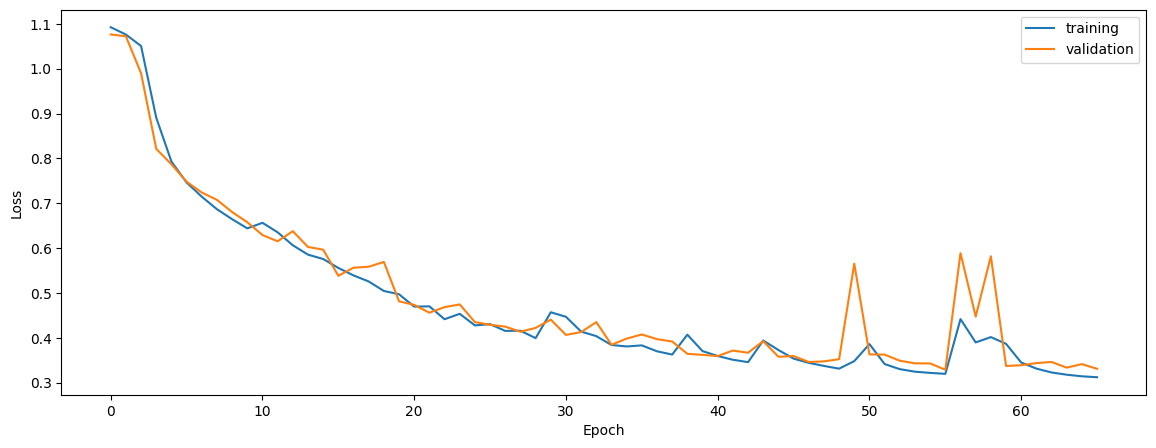

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.87227074482637


0.8711620286119512


0.8518833831398985


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.8831718913022859


0.8789586596744534


0.8599165263910347


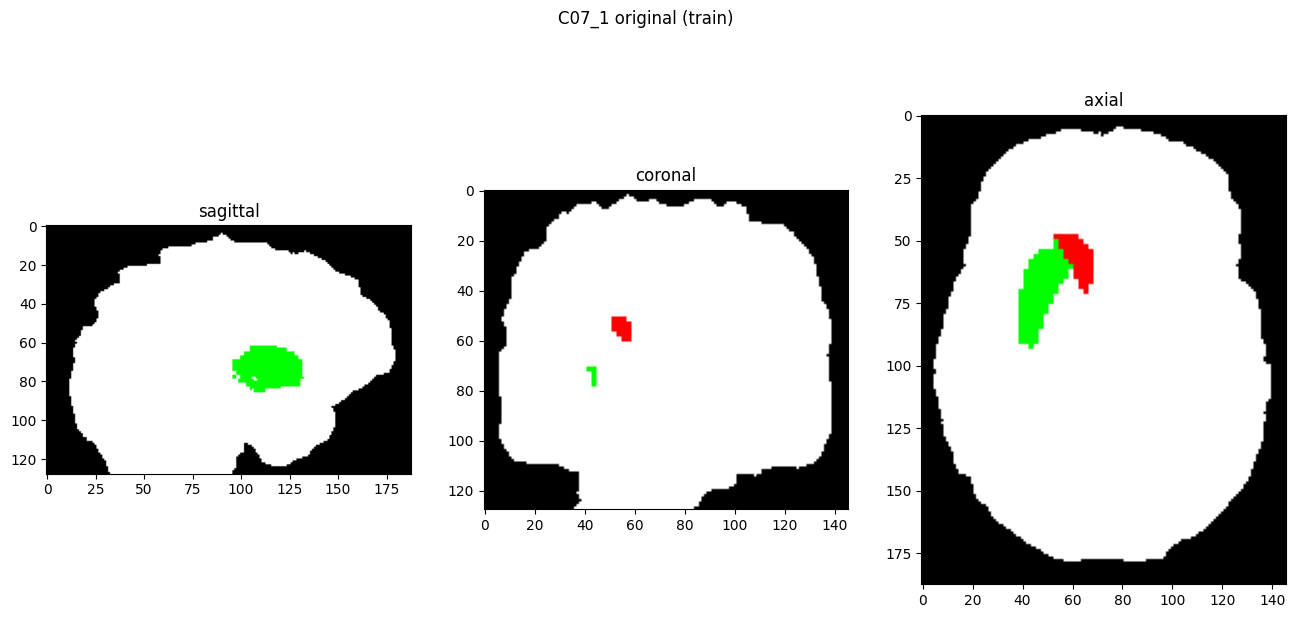

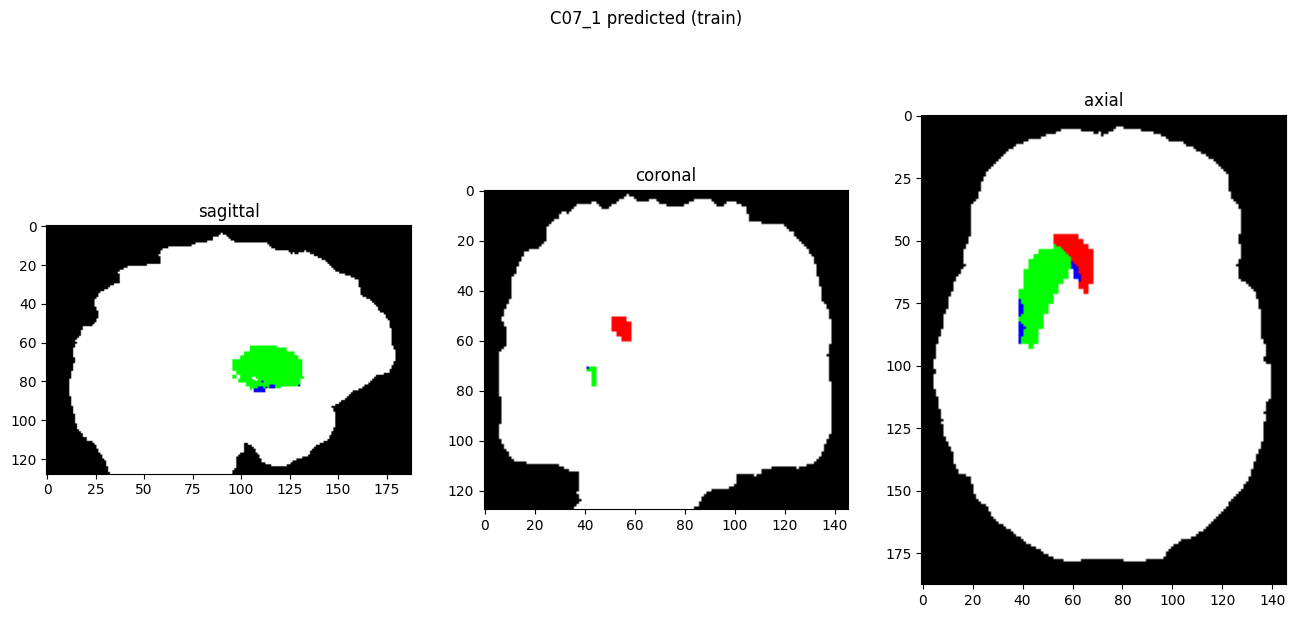

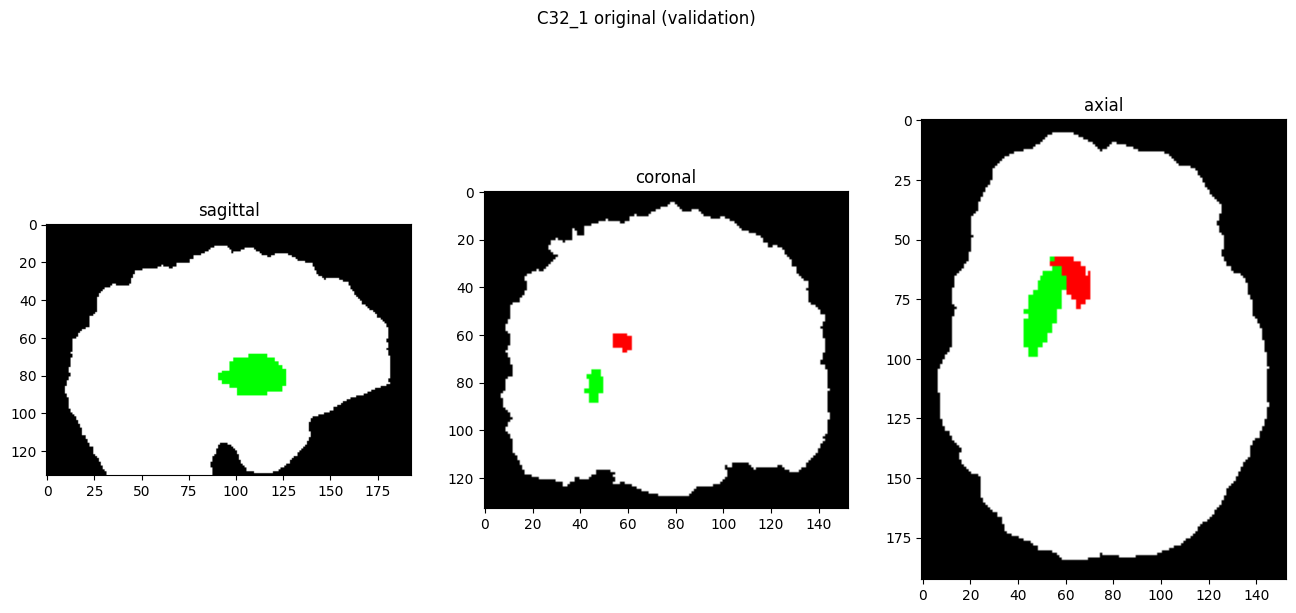

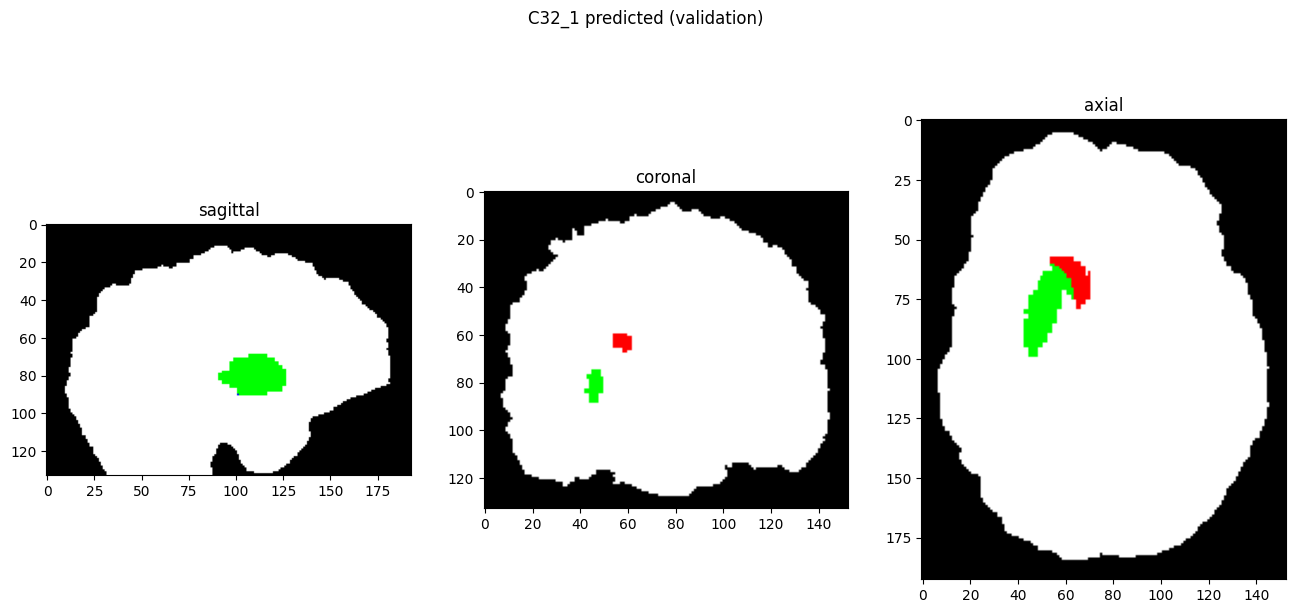

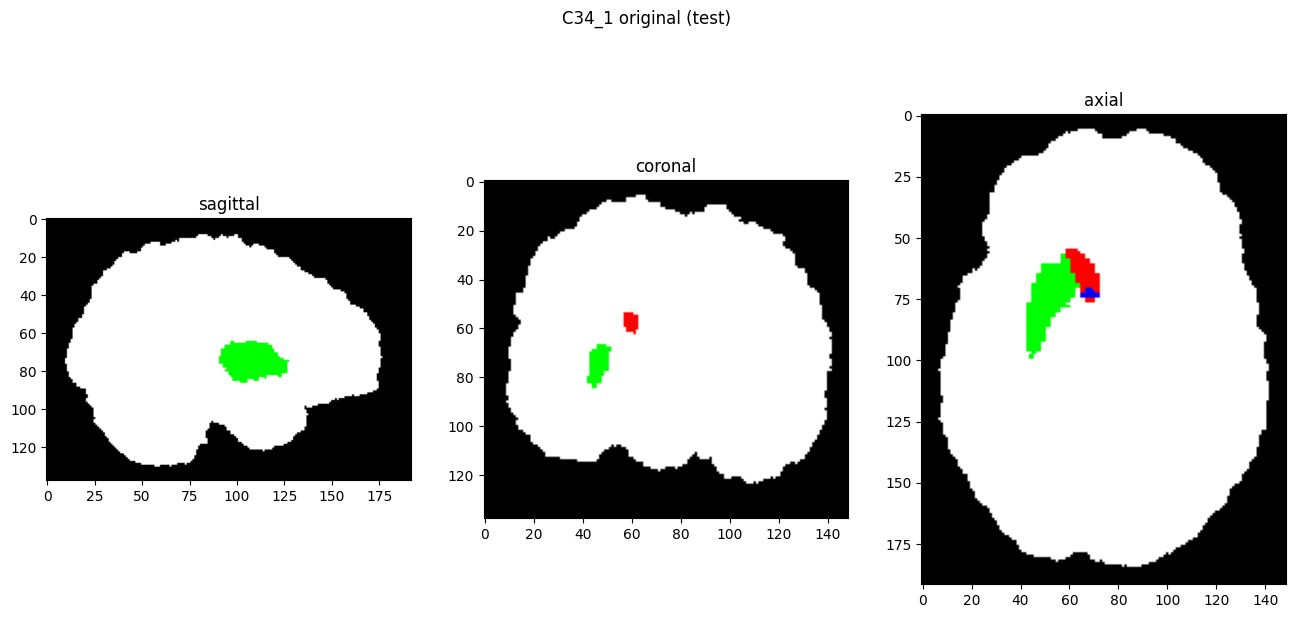

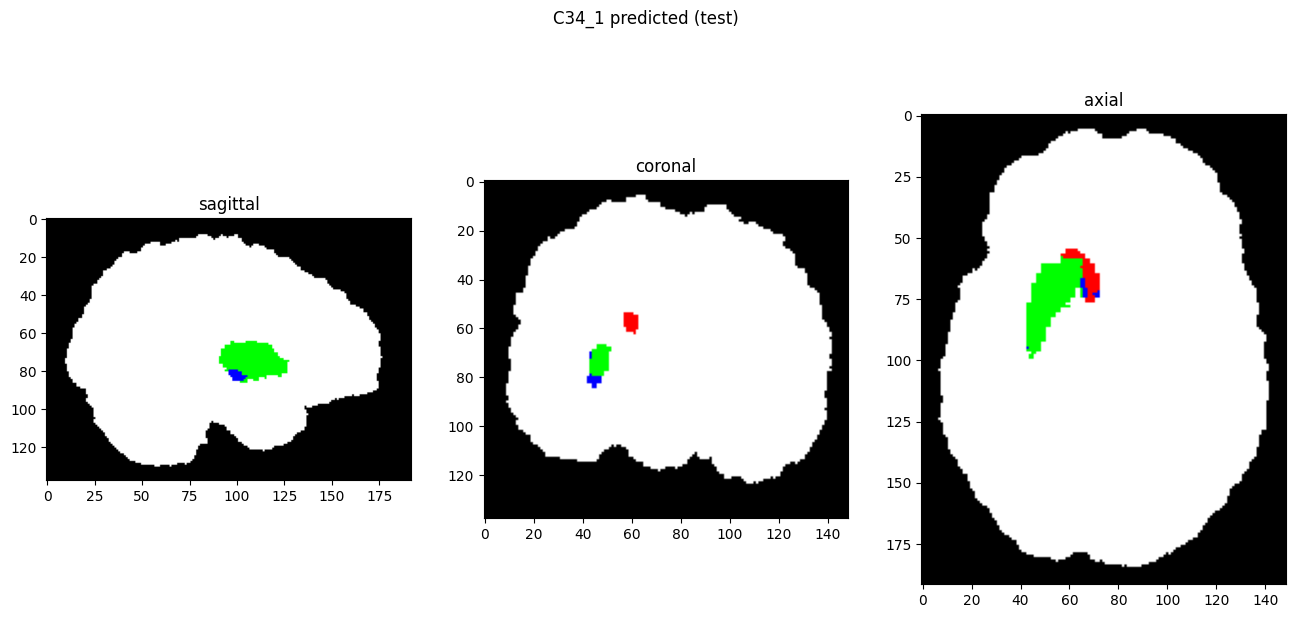

In [9]:
showResults(model, gen, threshold=0)